# Классификация туберкулёза

**Задача:** имплементация архитектуры EfficientNet b1 для бинарной классификации наличия/отсутствия туберкулёза по рентген-снимкам и апробация на реальных данных.

**Данные:** 
- открытый датасет с платформы kaggle Schenzhen для обучения и валидации
- открытый датасет с платформы kaggle Montgomery для тестирования
- закрытый датасет от Математического центра НГУ для апробации

**Метрика оценки качества модели:** ROC-AUC

## Загрузка данных

In [1]:
!pip install -q timm==0.5.4 pytorch_metric_learning randaugment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 12.5 MB/s eta 0:00:00


In [2]:
import os
import re
import PIL
import sys
import json
import time
import timm
import math
import copy
import torch
import pickle
import logging
import fnmatch
import argparse
import itertools
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import albumentations
import torch.nn as nn
from PIL import Image
from pathlib import Path
from copy import deepcopy
from sklearn import metrics
import torch.optim as optim
from datetime import datetime
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses
import torch.utils.model_zoo as model_zoo
from timm.models.layers.activations import *
from timm.utils import accuracy, AverageMeter
%config InlineBackend.figure_format = 'retina'
from collections import OrderedDict, defaultdict
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from randaugment import RandAugment, ImageNetPolicy, Cutout
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, auc, roc_auc_score

In [4]:
# подключение kaggle токена
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ekaterinaroppert","key":"e69fe3389391ea90f0e5b3fb41371848"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# загрузка обучающего и тестового датасета с kaggle
!kaggle datasets download -d raddar/tuberculosis-chest-xrays-shenzhen
!kaggle datasets download -d raddar/tuberculosis-chest-xrays-montgomery

100% 3.51G/3.51G [00:33<00:00, 143MB/s]
100% 3.51G/3.51G [00:34<00:00, 110MB/s]
 96% 561M/585M [00:03<00:00, 239MB/s]
100% 585M/585M [00:03<00:00, 179MB/s]


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# распаковка обучающей выборки
import zipfile
import os

archive_path = '/content/tuberculosis-chest-xrays-shenzhen.zip'
destination_folder = '/content/train'

os.makedirs(destination_folder, exist_ok=True)

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

extracted_files = os.listdir(destination_folder)
print('Распакованные файлы:')
for file in extracted_files:
    print(file)

Распакованные файлы:
images
shenzhen_metadata.csv


In [8]:
# перемещение обучающей выборки
import shutil

source_folder = 'train/images/images'
destination_folder = 'train'

file_list = os.listdir(source_folder)

for file_name in file_list:

    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    shutil.move(source_file, destination_file)

print("Файлы перемещены успешно!")

Файлы перемещены успешно!


In [9]:
# перемещаем файл с метаданными
source_file = 'train/shenzhen_metadata.csv'
destination_file = 'shenzhen_metadata.csv'
shutil.move(source_file, destination_file)

'shenzhen_metadata.csv'

In [10]:
# удаляем пустые папки
folder_path = 'train/images'
shutil.rmtree(folder_path)

print("Folder deleted successfully!")

Folder deleted successfully!


In [11]:
# распаковка тестовой выборки

archive_path = '/content/tuberculosis-chest-xrays-montgomery.zip'
destination_folder = '/content/test'

os.makedirs(destination_folder, exist_ok=True)

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

extracted_files = os.listdir(destination_folder)
print('Распакованные файлы:')
for file in extracted_files:
    print(file)

Распакованные файлы:
images
montgomery_metadata.csv


In [12]:
# перемещение тестовой выборки

source_folder = 'test/images/images'
destination_folder = 'test'

file_list = os.listdir(source_folder)

for file_name in file_list:

    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    shutil.move(source_file, destination_file)

print("Файлы перемещены успешно!")

Файлы перемещены успешно!


In [13]:
# перемещаем файл с метаданными
source_file = 'test/montgomery_metadata.csv'
destination_file = 'montgomery_metadata.csv'
shutil.move(source_file, destination_file)

'montgomery_metadata.csv'

In [14]:
# удаляем пустые папки
folder_path = 'test/images'
shutil.rmtree(folder_path)

print("Folder deleted successfully!")

Folder deleted successfully!


In [58]:
!pip install -q pyzipper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.7 MB/s eta 0:00:00


In [75]:
import pyzipper
file_name = '/content/drive/MyDrive/Colab Notebooks/bmm23_tub_png_anon.zip'
pswd = '2307'

os.makedirs('/content/test_2', exist_ok=True)

with pyzipper.AESZipFile(file_name) as zf:
    zf.extractall(path='/content/test_2', pwd = bytes(pswd, 'utf-8'))

In [76]:
# перемещение второй тестовой выборки
source_folder = '/content/test_2/bmm23_tub_png_anon/Norm'
destination_folder = 'test_2/normal'

file_list = os.listdir(source_folder)

os.makedirs('/content/test_2/normal', exist_ok=True)

for file_name in file_list:

    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    shutil.move(source_file, destination_file)

source_folder = '/content/test_2/bmm23_tub_png_anon/TB'
destination_folder = 'test_2/tb'

file_list = os.listdir(source_folder)

os.makedirs('/content/test_2/tb', exist_ok=True)

for file_name in file_list:

    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    shutil.move(source_file, destination_file)

print("Файлы перемещены успешно!")

Файлы перемещены успешно!


In [77]:
# удаляем пустые папки
folder_path = 'test_2/bmm23_tub_png_anon'
shutil.rmtree(folder_path)

print("Folder deleted successfully!")

Folder deleted successfully!


## Предобработка данных

In [15]:
# загрузка метаданных
train_df = pd.read_csv('shenzhen_metadata.csv')
test_df = pd.read_csv('montgomery_metadata.csv')

In [16]:
train_df.head()

study_id     sex  age findings
0  CHNCXR_0001_0.png    Male   45   normal
1  CHNCXR_0002_0.png    Male   63   normal
2  CHNCXR_0003_0.png  Female   48   normal
3  CHNCXR_0004_0.png    Male   58   normal
4  CHNCXR_0005_0.png    Male   28   normal

Последняя цифра (0 или 1) в названии файла - это метка класса. Из неё нужно сформировать целевую переменную.

In [17]:
train_target = []
for filename in train_df['study_id'].tolist():
    train_target.append(filename[-5])

In [18]:
train_df['target'] = train_target

In [19]:
train_df['target'] = train_df['target'].astype('int')

In [20]:
train_df.head()

study_id     sex  age findings  target
0  CHNCXR_0001_0.png    Male   45   normal       0
1  CHNCXR_0002_0.png    Male   63   normal       0
2  CHNCXR_0003_0.png  Female   48   normal       0
3  CHNCXR_0004_0.png    Male   58   normal       0
4  CHNCXR_0005_0.png    Male   28   normal       0

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   study_id  662 non-null    object
 1   sex       662 non-null    object
 2   age       662 non-null    int64 
 3   findings  662 non-null    object
 4   target    662 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 26.0+ KB


То же самое проделаем с тестовой выборкой.

In [22]:
test_df.head()

study_id  age  gender findings
0  MCUCXR_0001_0.png   27  Female   normal
1  MCUCXR_0002_0.png   40  Female   normal
2  MCUCXR_0003_0.png   21  Female   normal
3  MCUCXR_0004_0.png   11  Female   normal
4  MCUCXR_0005_0.png   33    Male   normal

In [23]:
test_target = []
for filename in test_df['study_id'].tolist():
    test_target.append(filename[-5])

In [24]:
test_df['target'] = test_target

In [25]:
test_df['target'] = test_df['target'].astype('int')

In [26]:
test_df.head()

study_id  age  gender findings  target
0  MCUCXR_0001_0.png   27  Female   normal       0
1  MCUCXR_0002_0.png   40  Female   normal       0
2  MCUCXR_0003_0.png   21  Female   normal       0
3  MCUCXR_0004_0.png   11  Female   normal       0
4  MCUCXR_0005_0.png   33    Male   normal       0

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   study_id  138 non-null    object
 1   age       138 non-null    int64 
 2   gender    138 non-null    object
 3   findings  138 non-null    object
 4   target    138 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 5.5+ KB


In [28]:
from sklearn.model_selection import train_test_split
features = train_df.drop('target', axis=1)
target = train_df['target']

X_train,X_valid, y_train, y_valid = train_test_split(features, target, test_size=.3, random_state=42, shuffle=True, stratify=target)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(463, 4)
(463,)
(199, 4)
(199,)


In [29]:
y_train.value_counts()

1    235
0    228
Name: target, dtype: int64

In [30]:
y_valid.value_counts()

1    101
0     98
Name: target, dtype: int64

Таким образом, у нас получились 2 сбалансированные выборки.

Теперь нужно переместить валидационную выборку в отдельную папку.

In [31]:
source_folder = 'train'
destination_folder = 'val'

os.makedirs('val')

file_list = X_valid['study_id'].tolist()

for file_name in file_list:

    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    shutil.move(source_file, destination_file)

print("Файлы перемещены успешно!")

Файлы перемещены успешно!


Далее нам нужно сделать так, чтобы в каждой папке по отдельным папкам лежали классы.

In [32]:
train_df = X_train.copy()
train_df['target'] = y_train
val_df = X_valid.copy()
val_df['target'] = y_valid

In [33]:
train_normal = train_df.query('target == 0')['study_id'].tolist()
train_tb = train_df.query('target == 1')['study_id'].tolist()

In [34]:
# перемещаем нормальные снимки обучающей выборки в папку train/normal
source_folder = 'train'
destination_folder = 'train/normal'

os.makedirs(os.path.join('train', 'normal'))

for file_name in train_normal:
    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    shutil.move(source_file, destination_file)

print("Файлы перемещены успешно!")

# перемещаем снимки с туберкулёзом обучающей выборки в папку train/tb
source_folder = 'train'
destination_folder = 'train/tb'

os.makedirs(os.path.join('train', 'tb'))

for file_name in train_tb:
    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    shutil.move(source_file, destination_file)

Файлы перемещены успешно!


In [35]:
val_normal = val_df.query('target == 0')['study_id'].tolist()
val_tb = val_df.query('target == 1')['study_id'].tolist()

# перемещаем нормальные снимки валидационной выборки в папку val/normal
source_folder = 'val'
destination_folder = 'val/normal'

os.makedirs(os.path.join('val', 'normal'))

for file_name in val_normal:
    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    shutil.move(source_file, destination_file)

print("Файлы перемещены успешно!")

# перемещаем снимки с туберкулёзом валидационной выборки в папку val/tb
source_folder = 'val'
destination_folder = 'val/tb'

os.makedirs(os.path.join('val', 'tb'))

for file_name in val_tb:
    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    shutil.move(source_file, destination_file)

print("Файлы перемещены успешно!")

Файлы перемещены успешно!
Файлы перемещены успешно!


In [36]:
test_normal = test_df.query('target == 0')['study_id'].tolist()
test_tb = test_df.query('target == 1')['study_id'].tolist()

# перемещаем нормальные снимки тестовой выборки в папку test/normal
source_folder = 'test'
destination_folder = 'test/normal'

os.makedirs(os.path.join('test', 'normal'))

for file_name in test_normal:
    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    shutil.move(source_file, destination_file)

print("Файлы перемещены успешно!")

# перемещаем снимки с туберкулёзом тестовой выборки в папку test/tb
source_folder = 'test'
destination_folder = 'test/tb'

os.makedirs(os.path.join('test', 'tb'))

for file_name in test_tb:
    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    shutil.move(source_file, destination_file)

print("Файлы перемещены успешно!")

Файлы перемещены успешно!
Файлы перемещены успешно!


## Трансформации

In [78]:
# задаём трансформации для обучающей и тестовой выборок
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        RandAugment(),
        ImageNetPolicy(),
        Cutout(size=16),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),

    'test_2': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [79]:
# загружаем датасеты в ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test', 'test_2']}
batch_size = 70
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=8, pin_memory = True)
              for x in ['train', 'val', 'test', 'test_2']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test', 'test_2']}

class_names = image_datasets['train'].classes
print(class_names)
print(dataset_sizes)
print(device)

### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['train'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
print(cat_to_name)

# Run this to test the data loader
images, labels = next(iter(data_loader['val']))
images.size()

['normal', 'tb']
{'train': 463, 'val': 199, 'test': 138, 'test_2': 24}
cuda:0
{0: 'normal', 1: 'tb'}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([70, 3, 224, 224])

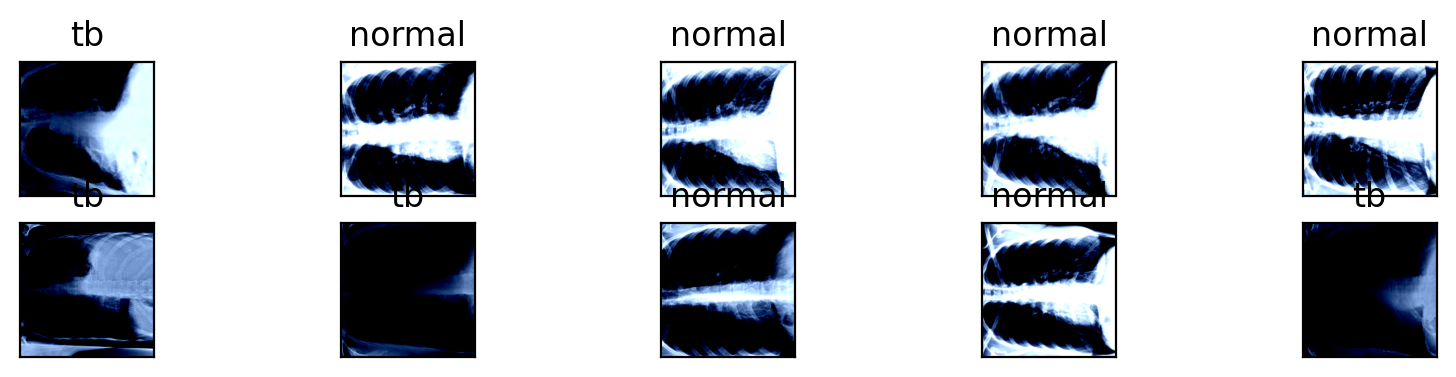

In [80]:
def showimage(data_loader, number_images, cat_to_name):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images = images.numpy()

    fig = plt.figure(figsize=(number_images, 4))
    for idx in np.arange(number_images):
        ax = fig.add_subplot(4, int(number_images/2), idx+1, xticks=[], yticks=[])
        img = np.transpose(images[idx])
        plt.imshow(img)
        ax.set_title(cat_to_name[labels.tolist()[idx]])

showimage(data_loader['test_2'], 10, cat_to_name)

## Обучение модели

In [43]:
model = timm.create_model('efficientnet_b1', pretrained=True, drop_rate=0.2)
model.classifier

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth


Linear(in_features=1280, out_features=1000, bias=True)

In [44]:
# создаём классификатор
for param in model.parameters():
    param.requires_grad = True

fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
                                ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
                                ('dropout1', nn.Dropout(0.7)),
                                ('fc2', nn.Linear(1000, 512)),
                                ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
                                ('swish1', Swish()),
                                ('dropout2', nn.Dropout(0.5)),
                                ('fc3', nn.Linear(512, 128)),
                                ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
                                ('swish2', Swish()),
                                ('fc4', nn.Linear(128, 2)),
                                ('output', nn.Softmax(dim=1))
                            ]))

# присоединяем классификатор к предобученной сети
model.fc = fc
criterion = LabelSmoothingCrossEntropy()

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

model.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print("The number of parameters of the model is:", count)

The number of parameters of the model is: 10424898


In [50]:
model.to(device)
def train_model(model, criterion, optimizer, scheduler, num_epochs=200, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    # Tensorboard summary
    writer = SummaryWriter()
    start_time_per_epoch = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 20)

        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0
           
            for i, (inputs, labels) in enumerate(data_loader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                if i % 1000 == 999:
                    print('[%d, %d] loss: %.8f' %
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.8f} Acc: {:.8f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
                writer.flush()
            else:
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)
                writer.flush()


            if phase == 'val' and epoch_acc > best_acc:
                print(f'New best model found!')
                print(f'New record ACC: {epoch_acc}, previous record acc: {best_acc}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'best_val_loss': best_loss,
                            'best_val_accuracy': best_acc,
                            'scheduler_state_dict' : scheduler.state_dict(),
                            },
                            CHECK_POINT_PATH
                            )
                print(f'New record acc is SAVED: {epoch_acc}')

        end_time_per_epoch = (time.time() - start_time_per_epoch)
        print('Time for training the last epoch: {:.0f}m {:.0f}s'.format(
        end_time_per_epoch // 60, end_time_per_epoch % 60))

    time_elapsed = time.time() - since
    print('Total training time complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.8f} Best val loss: {:.8f}'.format(best_acc, best_loss))


    # загружаем веса лучшей модели
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [ ]:
# архитектура модели
model

In [65]:
%time
# обучение модели
CHECK_POINT_PATH = 'weights'

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
if checkpoint == None:
    CHECK_POINT_PATH = CHECK_POINT_PATH
model, best_val_loss, best_val_acc = train_model(model,
                                                 criterion,
                                                 optimizer,
                                                 scheduler,
                                                 num_epochs = 100,
                                                 checkpoint = None
                                                 )

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict': scheduler.state_dict(),
            }, CHECK_POINT_PATH)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 14.8 µs
checkpoint loaded
Epoch 1/100
--------------------
train Loss: 1.32093049 Acc: 0.84665227
val Loss: 1.22527713 Acc: 0.91457286
New best model found!
New record ACC: 0.914572864321608, previous record acc: 0.0
New record acc is SAVED: 0.914572864321608
Time for training the last epoch: 1m 42s
Epoch 2/100
--------------------
train Loss: 1.28540322 Acc: 0.87473002
val Loss: 1.21987098 Acc: 0.91959799
New best model found!
New record ACC: 0.9195979899497487, previous record acc: 0.914572864321608


Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 250, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurre

New record acc is SAVED: 0.9195979899497487
Time for training the last epoch: 3m 29s
Epoch 3/100
--------------------
train Loss: 1.29610832 Acc: 0.85745140
val Loss: 1.21778057 Acc: 0.92462312
New best model found!
New record ACC: 0.9246231155778895, previous record acc: 0.9195979899497487
New record acc is SAVED: 0.9246231155778895
Time for training the last epoch: 5m 18s
Epoch 4/100
--------------------
train Loss: 1.30691345 Acc: 0.85961123
val Loss: 1.21686724 Acc: 0.92462312
Time for training the last epoch: 7m 1s
Epoch 5/100
--------------------
train Loss: 1.33212056 Acc: 0.84665227
val Loss: 1.21295351 Acc: 0.92462312
Time for training the last epoch: 8m 49s
Epoch 6/100
--------------------
train Loss: 1.29888598 Acc: 0.85529158
val Loss: 1.21297364 Acc: 0.92462312
Time for training the last epoch: 10m 35s
Epoch 7/100
--------------------
train Loss: 1.30265472 Acc: 0.86393089
val Loss: 1.21357026 Acc: 0.92462312
Time for training the last epoch: 12m 24s
Epoch 8/100
----------

KeyboardInterrupt: ignored

Лучший ACC на валидации: 0.9246

Лучший лосс: 1.2177

In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.suam(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

## Тестирование на Montgomery

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.78 µs
checkpoint loaded


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Inference time is 0m 43s
              precision    recall  f1-score   support

           0     0.7767    1.0000    0.8743        80
           1     1.0000    0.6034    0.7527        58

    accuracy                         0.8333       138
   macro avg     0.8883    0.8017    0.8135       138
weighted avg     0.8706    0.8333    0.8232       138



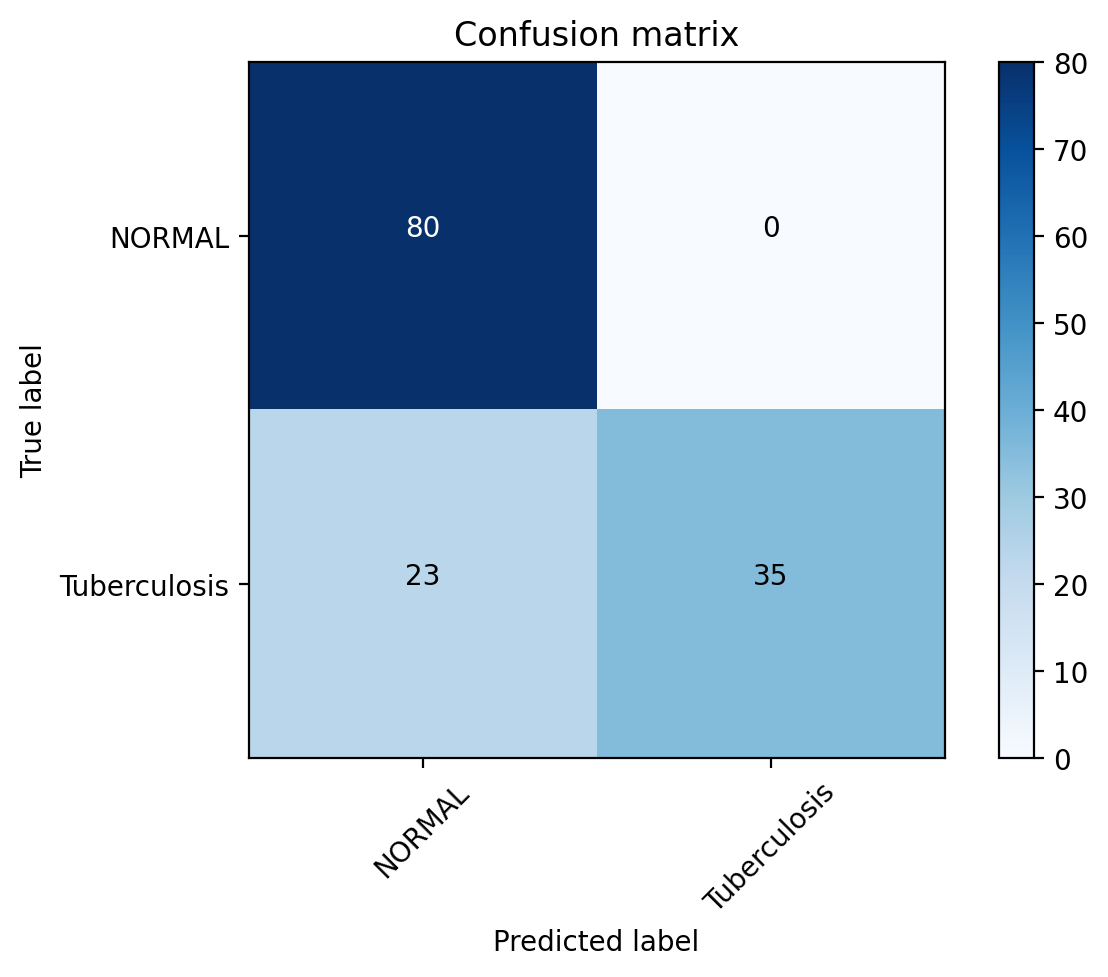

In [83]:
%time
CHECK_POINT_PATH = 'weights'

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH)
model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['test']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

time_elapsed = time.time() - since

print('Inference time is {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


confusion_mtx = confusion_matrix(y_label, y_predict)
plot_labels = ['NORMAL', 'Tuberculosis']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)

ROC curve (area = 0.8017)


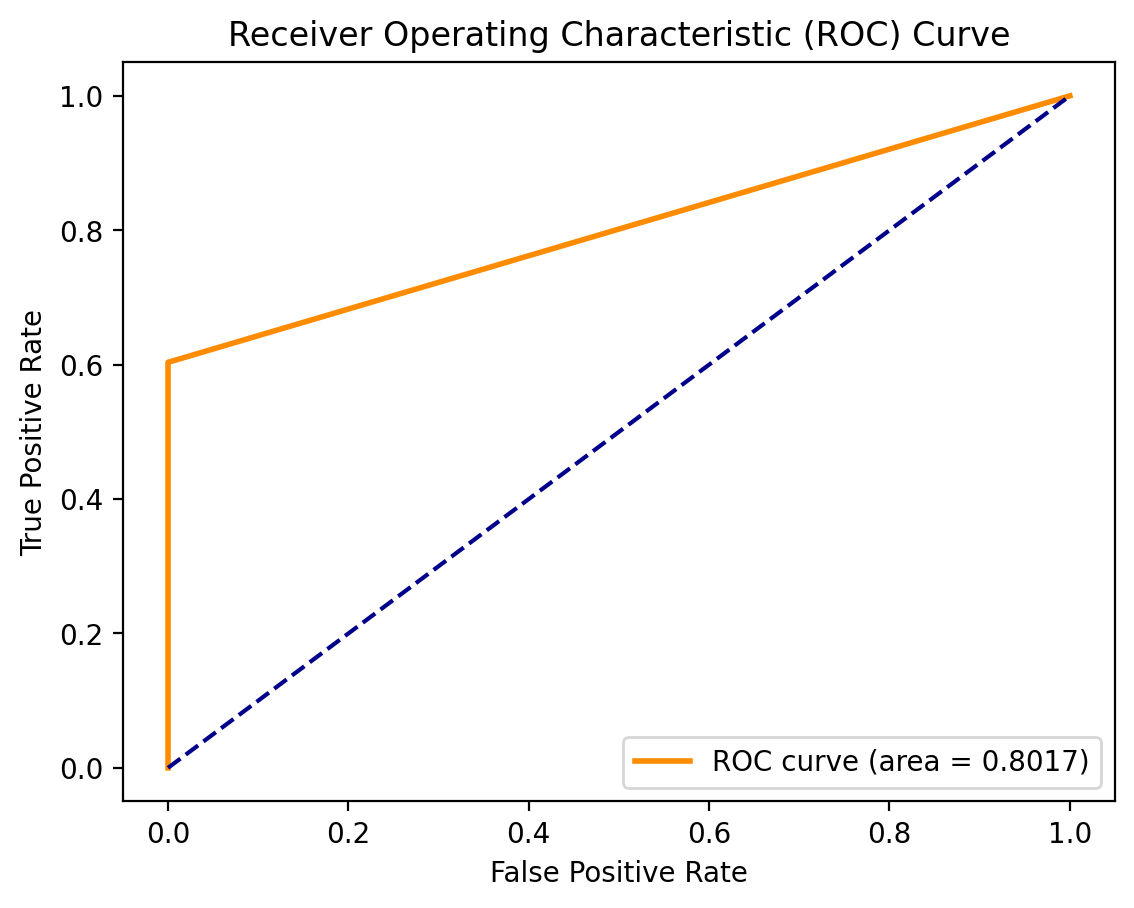

In [84]:
roc_auc = roc_auc_score(y_label, y_predict)
print('ROC curve (area = %0.4f)' % roc_auc)
fpr, tpr, thresholds = roc_curve(y_label, y_predict)
plot_roc_curve(fpr, tpr)

## Тестирование на реальных данных

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 12.4 µs
checkpoint loaded
Inference time is 0m 4s
              precision    recall  f1-score   support

           0     0.7500    0.8000    0.7742        15
           1     0.6250    0.5556    0.5882         9

    accuracy                         0.7083        24
   macro avg     0.6875    0.6778    0.6812        24
weighted avg     0.7031    0.7083    0.7045        24



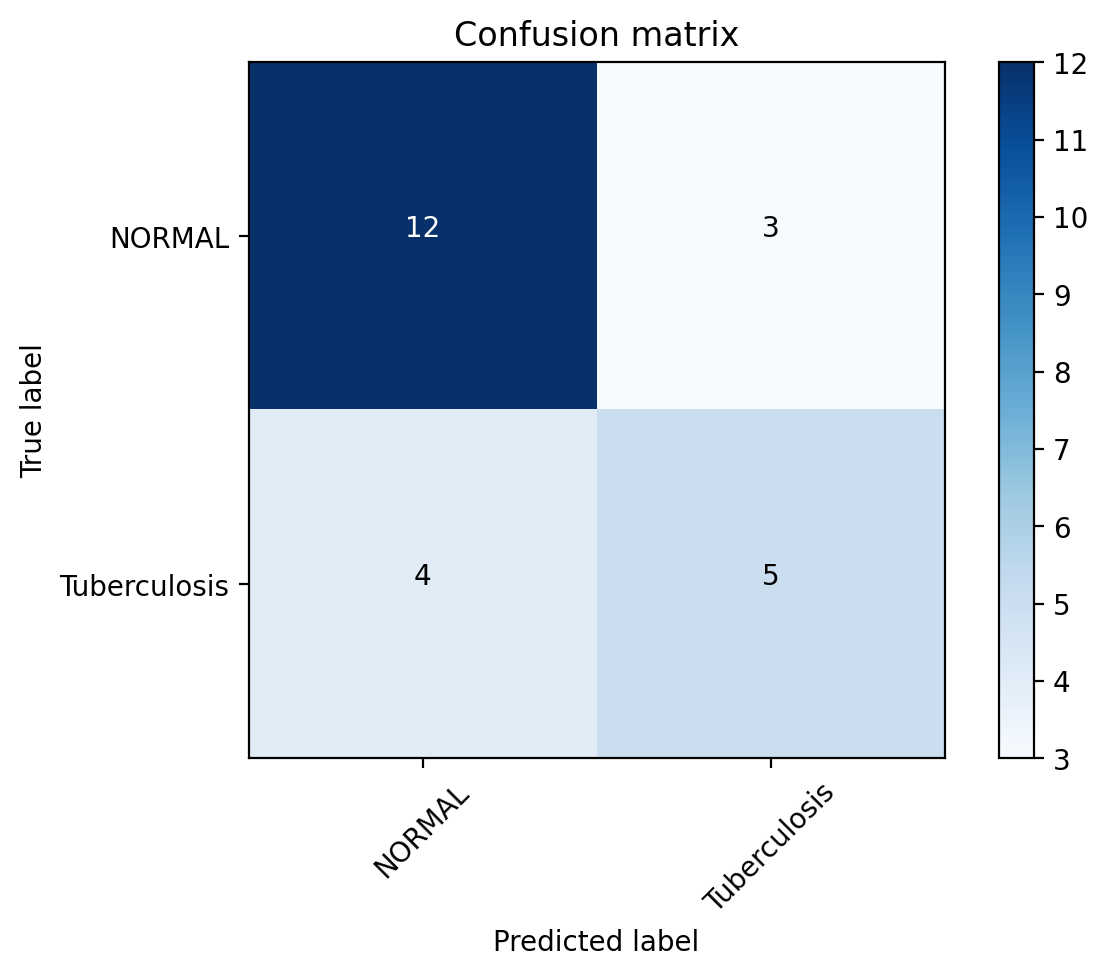

In [81]:
%time
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH)
model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['test_2']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

time_elapsed = time.time() - since

print('Inference time is {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

confusion_mtx = confusion_matrix(y_label, y_predict)
plot_labels = ['NORMAL', 'Tuberculosis']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)

ROC curve (area = 0.6778)


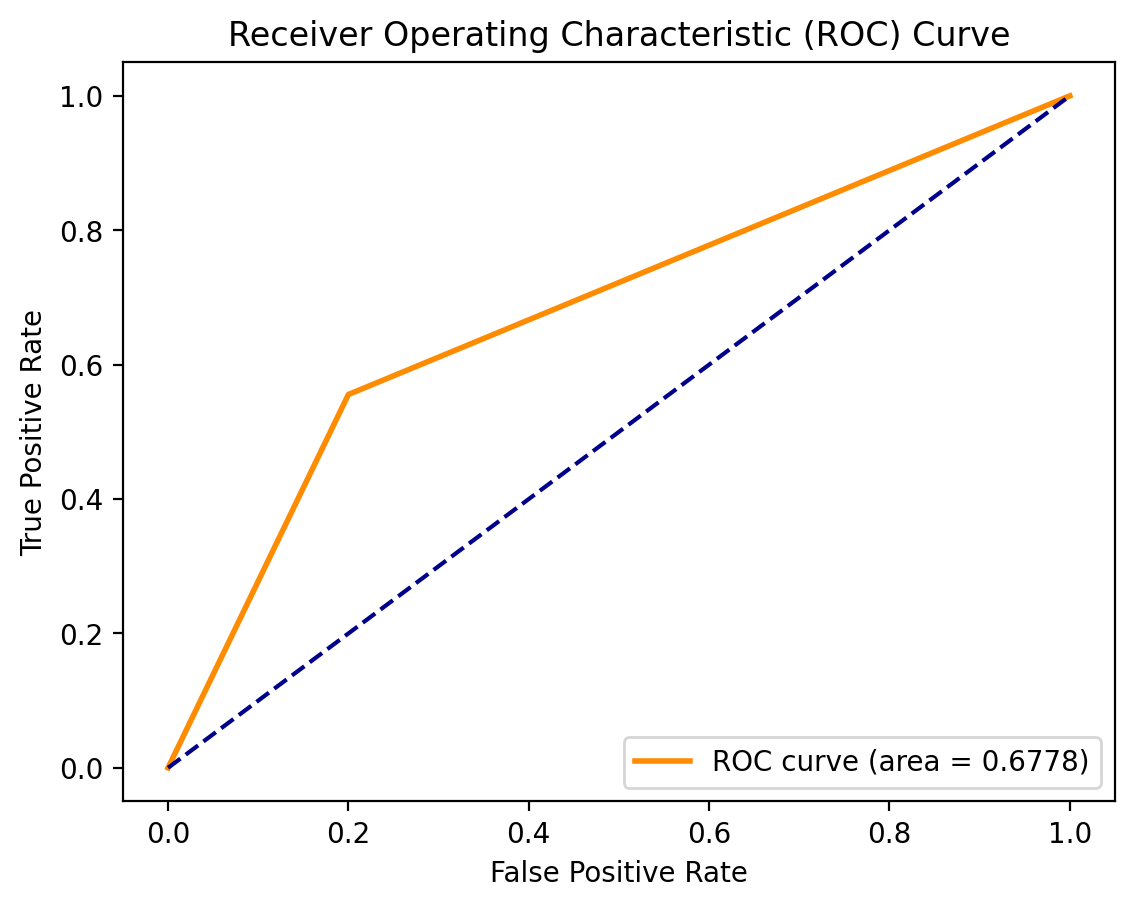

In [82]:
roc_auc = roc_auc_score(y_label, y_predict)
print('ROC curve (area = %0.4f)' % roc_auc)
fpr, tpr, thresholds = roc_curve(y_label, y_predict)
plot_roc_curve(fpr, tpr)

ROC-AUC на тесте: 0.8

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


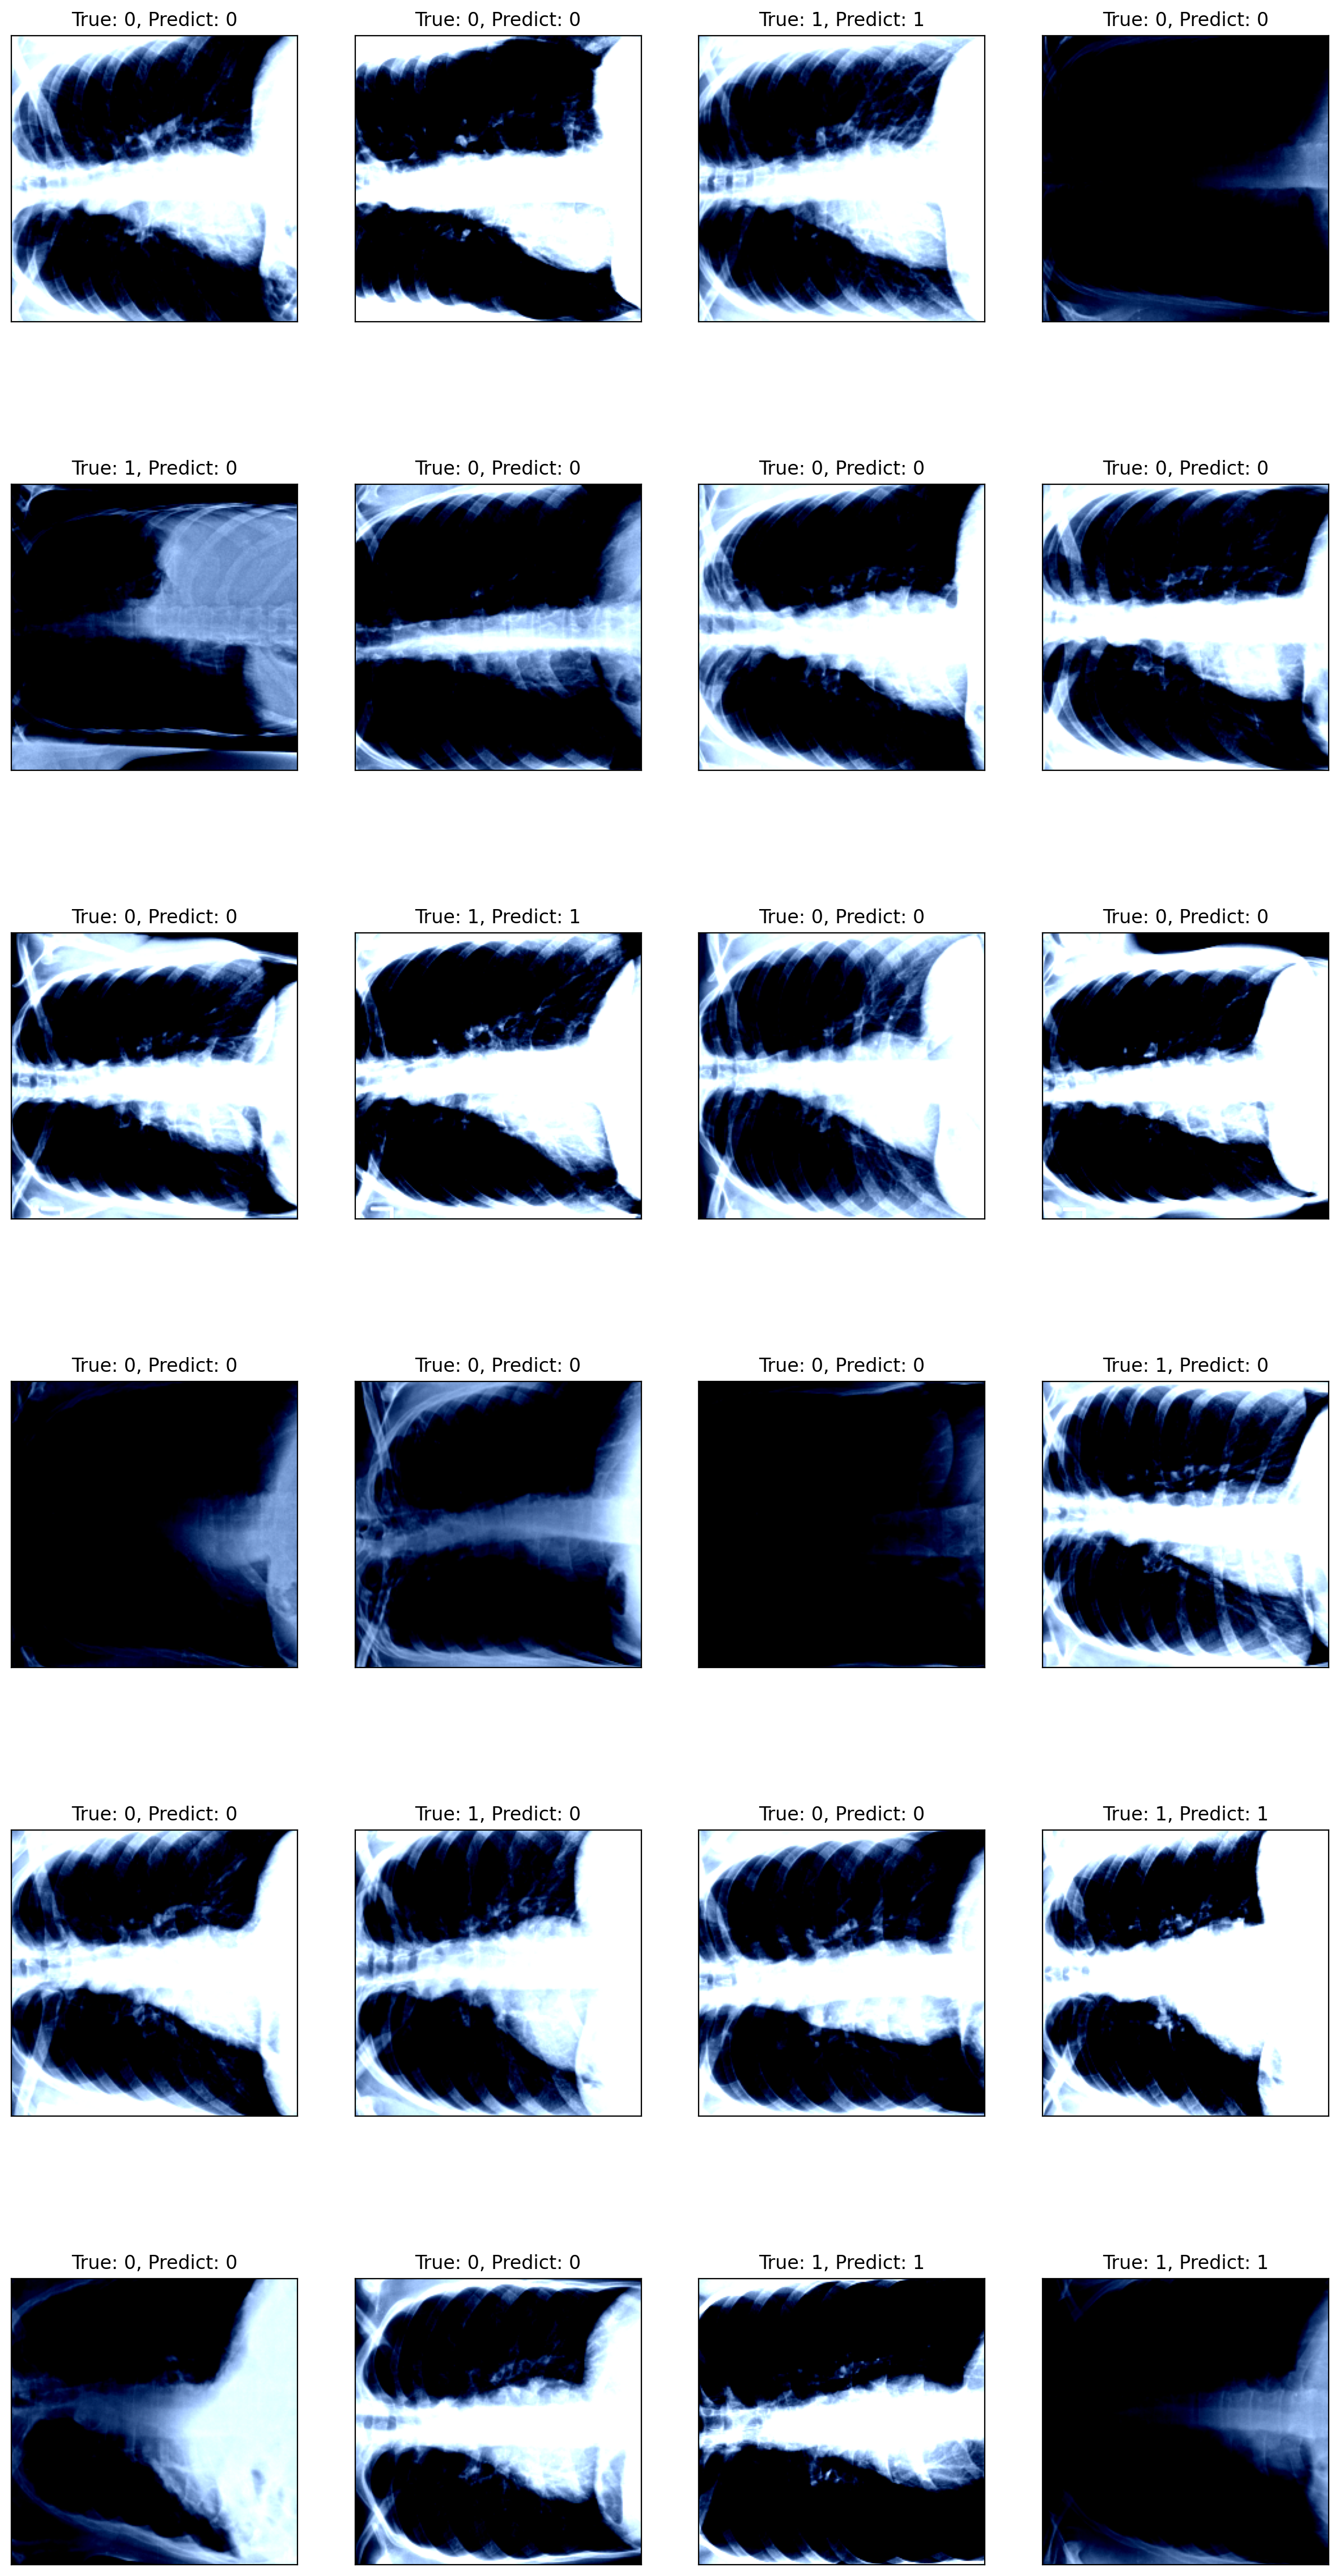

In [108]:
# визуализация по пациентам
dataiter = iter(data_loader['test_2'])
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(15, 30))
for idx in np.arange(24):
    ax = fig.add_subplot(6, 4, idx+1, xticks=[], yticks=[])
    img = np.transpose(images[idx])
    plt.imshow(img)
    ax.set_title(f"True: {y_label[idx]}, Predict: {y_predict[idx]}, Coeff: {outputs.cpu().numpy()[idx].mean()}")

plt.show()

## Вывод

Модель на основе архитектуры EfficientNet b1 хорошо показала себя в работе на реальных данных: она верно определила наличие туберкулёза в 21 случае из 24. Ошибки в трёх случаях связаны с особенностью данных: на них в двух случаях изображены признаки застарелого перенесённого туберкулёза, а в другом случае - следы резекции лёгких. В дальнейшем можно дообучить модель на большем количестве данных и свести количество ошибок к нулю. 